# **CA4 @ AI Spring 2025**
# Convolutional vs. Fully Connected Neural Networks

- **Name: Kian**
- **Student ID: 810003008**

---
Your submission should be named using the following format: `AI_CA4_LASTNAME_STUDENTID.ipynb`.

---

 *How to do this problem set:*

- Some questions require writing Python code and computing results, and the rest of them have written answers. For coding problems, you will have to fill out all code blocks that say `YOUR CODE HERE`.

- For text-based answers, you should replace the text that says `WRITE YOUR ANSWER HERE` with your actual answer.
---
If you have any further questions or concerns, contact the TAs via email or Telegram.

# Introduction
In this assignment, you will compare fully connected neural networks with convolutional neural networks to evaluate whether convolutional architectures offer superior performance—and understand the reasons behind any observed differences.

**Important Note:**

Before you begin, please make sure to review the accompanying PyTorch tutorial provided alongside this file.

## Colab Setup

If you are running this notebook on Google Colab, you can mount your Google Drive using the following code to access or upload files directly from your Drive.

## Device

As demonstrated in the PyTorch tutorial, PyTorch enable you to run your code on GPU to accelerate computations.

In [1]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Dataset

## Transforms & Dataset & Dataloader

Here, you should download and load the dataset with the desire transforms. After that, you should split train dataset to train and validation sets. Finally, define the dataloaders for `train`, `validation` and `test`

In [2]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
from torchvision import transforms

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),     # pad 4 pixels on each side, then random‐crop 32×32
    transforms.RandomHorizontalFlip(p=0.5),   # 50% chance to flip horizontally
    transforms.ToTensor(),
    transforms.Normalize((0.491, 0.482, 0.446),
                         (0.247, 0.243, 0.261)),
])


In [4]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] 
from torchvision import transforms

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)),
]) 
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torchvision

batch_size = 1024

initial_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainset, valset = random_split(initial_trainset, [45000, 5000])

trainloader = DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,      # ↑
    pin_memory=True
)
valloader = DataLoader(valset,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


## Visualization

Visualize 5 random images from each class in different columns

- **Hint**:  You can use `plt.subplots` for visualization

In [5]:
# inverse the normilize transform to restore the original data
import torch

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def __call__(self, tensor, gray=False, coeff=(0.3, 0.59, 0.11)):
        if gray:
            tensor = tensor * self.std.view(-1, 1, 1) + self.mean.view(-1, 1, 1)
            r, g, b = tensor[0], tensor[1], tensor[2]
            gray_tensor = r * coeff[0] + g * coeff[1] + b * coeff[2]
            return gray_tensor
        else:
            return tensor * self.std.view(-1, 1, 1) + self.mean.view(-1, 1, 1)


norminv = UnNormalize(mean=(0.491, 0.482, 0.446), std=(0.247, 0.243, 0.261))

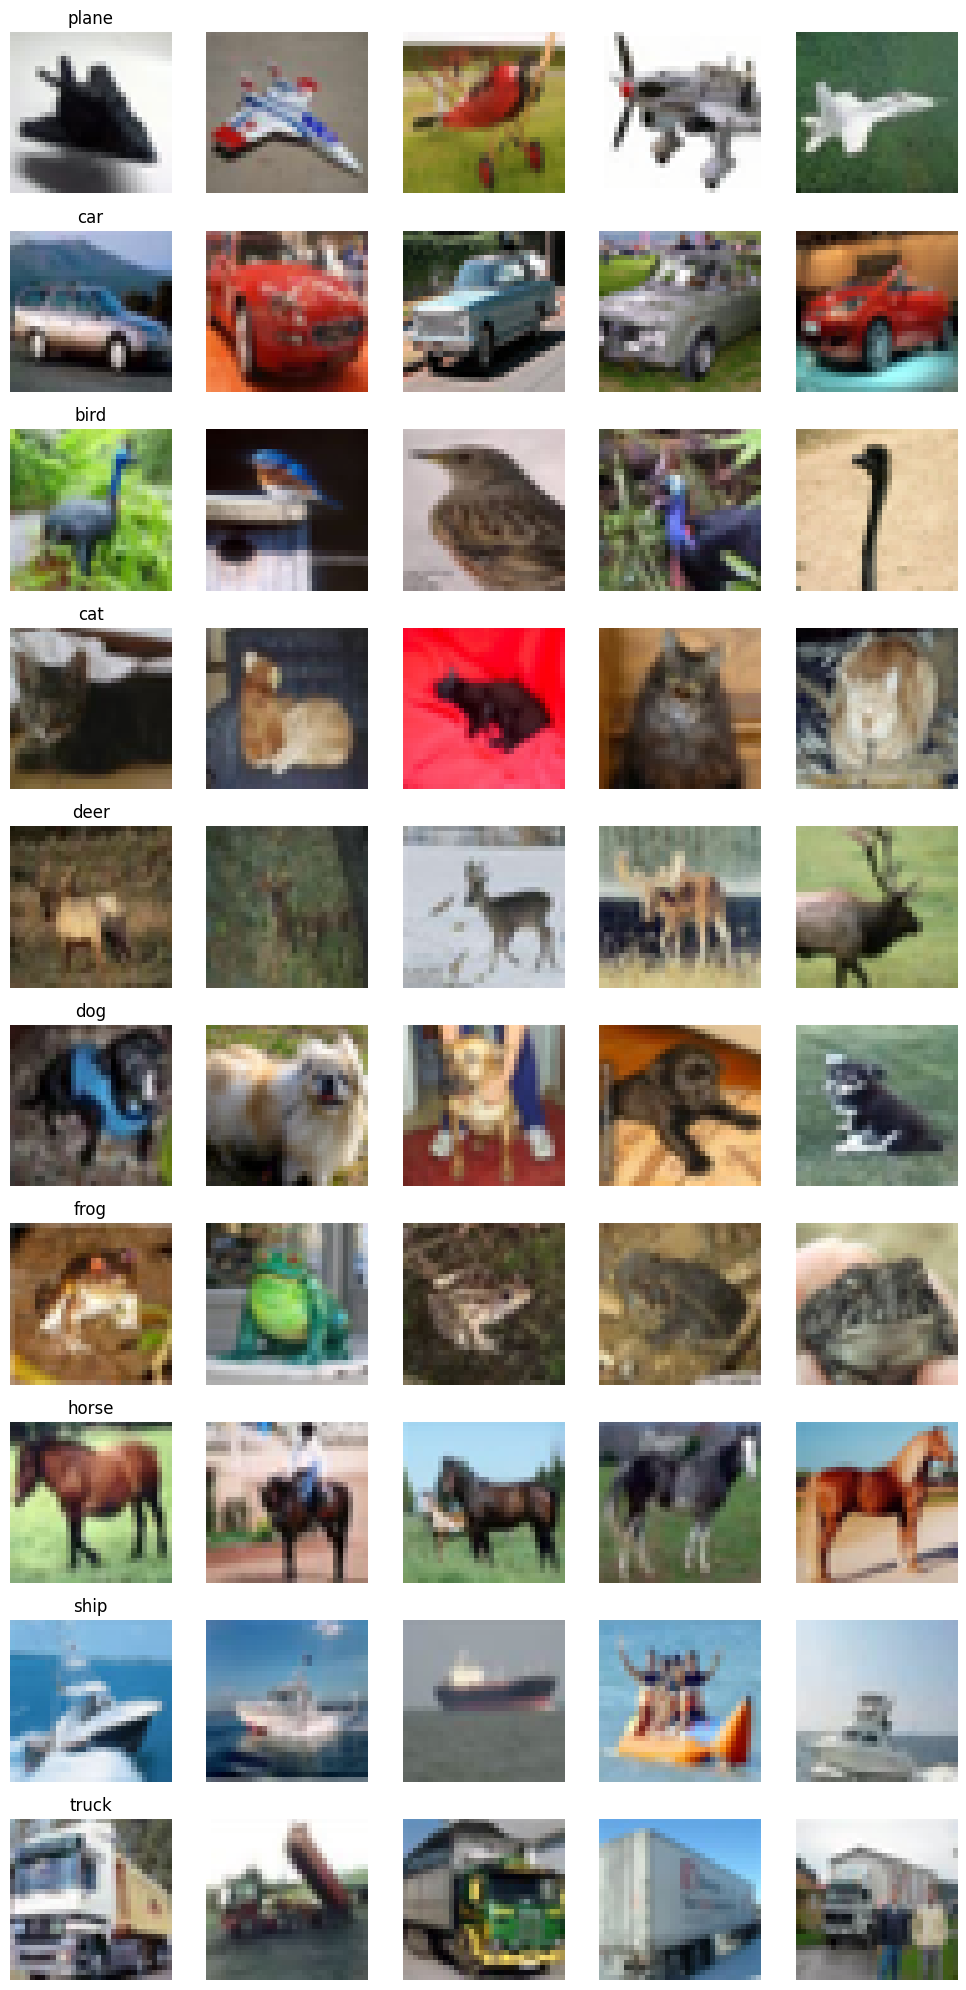

In [6]:
import matplotlib.pyplot as plt
import torchvision
import random
import numpy as np

# Load the full training set with transform (already normalized)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

# Group images by class
class_to_imgs = {i: [] for i in range(10)}

for img, label in trainset:
    if len(class_to_imgs[label]) < 5:
        class_to_imgs[label].append(img)
    if all(len(imgs) == 5 for imgs in class_to_imgs.values()):
        break

# Plotting
fig, axs = plt.subplots(10, 5, figsize=(10, 20))
for class_idx in range(10):
    for i in range(5):
        img = norminv(class_to_imgs[class_idx][i])
        img = img.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
        axs[class_idx, i].imshow(np.clip(img, 0, 1))
        axs[class_idx, i].axis('off')
        if i == 0:
            axs[class_idx, i].set_title(classes[class_idx])
plt.tight_layout()
plt.show()


# Fully Connected Neural Netwrok

Your first task is to build a fully connected neural network with PyTorch. To achieve this, it is recommended that you familiarize yourself with the following PyTorch components and incorporate them into your network architecture:

* [`nn.Module`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Module.html)
* [`nn.Sequential`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Sequential.html)
* [`nn.Linear`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html)
* [`nn.ReLU`](https://docs.pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
* [`nn.Dropout`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Dropout.html)
* [`nn.Flatten`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Flatten.html)

In the provided template below, the final layer of the model should be defined separately and assigned the name `linear`, as it will be referenced in a later section of this assignment.

To ensure a fair comparison with convolutional neural networks (CNNs), both models should have approximately the same number of trainable parameters. Specifically, the fully connected model should contain **33,500,000 ± 500,000** trainable parameters.

You will calculate the exact number of trainable parameters in the following subsection to ensure this requirement is met.




In [7]:
import torch.nn as nn

class FullyConnectedNetwork(nn.Module):
    def __init__(self, input_shape=(3, 32, 32), num_classes=10):
        super(FullyConnectedNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.net = nn.Sequential(
            nn.Linear(3*32*32, 5120),
            nn.BatchNorm1d(5120),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(5120, 2560),
            nn.BatchNorm1d(2560),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(2560, 1280),
            nn.BatchNorm1d(1280),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(1280, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
        )
        self.linear = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.net(x)
        x = self.linear(x)
        return x


## Trainable params

Based on the defined architecture, manually calculate the total number of trainable parameters:

Layer 1: Linear(3072 → 5120)

Weights: 3072 × 5120 = 15,728,640

Biases: 5120

Total: 15,728,640 + 5120 = 15,733,760

Layer 2: Linear(5120 → 2560)

Weights: 5120 × 2560 = 13,107,200

Biases: 2560

Total: 13,107,200 + 2560 = 13,109,760

Layer 3: Linear(2560 → 1280)

Weights: 2560 × 1280 = 3,276,800

Biases: 1280

Total: 3,276,800 + 1280 = 3,278,080

Layer 4: Linear(1280 → 1024)

Weights: 1280 × 1024 = 1,310,720

Biases: 1024

Total: 1,310,720 + 1024 = 1,311,744

Layer 5: Linear(1024 → 10)

Weights: 1024 × 10 = 10,240

Biases: 10

Total: 10,240 + 10 = 10,250 
, so I now sum'em up : 
15,733,760 +
13,109,760 +
 3,278,080 +
 1,311,744 +
    10,250
= 33,443,594


Once you have completed your hand calculation, you can verify your result by running the following cell:

In [8]:
from torchsummary import summary
summary(FullyConnectedNetwork().to(device), input_size=(3, 32, 32));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                 [-1, 5120]      15,733,760
       BatchNorm1d-3                 [-1, 5120]          10,240
              ReLU-4                 [-1, 5120]               0
           Dropout-5                 [-1, 5120]               0
            Linear-6                 [-1, 2560]      13,109,760
       BatchNorm1d-7                 [-1, 2560]           5,120
              ReLU-8                 [-1, 2560]               0
           Dropout-9                 [-1, 2560]               0
           Linear-10                 [-1, 1280]       3,278,080
      BatchNorm1d-11                 [-1, 1280]           2,560
             ReLU-12                 [-1, 1280]               0
          Dropout-13                 [-1, 1280]               0
           Linear-14                 [-

## Train

### Model Instantiation

Create an instance of your model and move it to your selected device (CPU or GPU). Refer to the PyTorch-tutorial notebook for guidance on how to perform this operation.

In [9]:
model = FullyConnectedNetwork().to(device)

### Criterion & Optimizer


To train a neural network, we require a **loss function** (referred to as the *criterion*) to quantify the difference between the model's predictions and the true labels. This loss is then used to compute the gradients of the model parameters.

In addition, an **optimization algorithm** is needed to update the model's parameters using the calculated gradients, in order to minimize the loss over time.

You are encouraged to read about the following PyTorch components:

* [`nn.CrossEntropyLoss`](https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
* [`torch.optim.Adam`](https://docs.pytorch.org/docs/stable/generated/torch.optim.Adam.html)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scaler = torch.cuda.amp.GradScaler()

C:\Users\kian\AppData\Local\Temp\ipykernel_11036\3797817210.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


### Train loop

Train your model

Tasks:
- Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- save train/validation loss and accuracy (of each epoch) in an array for later usage

In [11]:
def train_epoch(net: torch.nn.Module,
                criterion: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                dataloader: torch.utils.data.DataLoader):
    """
    Trains the neural network for a single epoch.

    Args:
        net (torch.nn.Module): The neural network model to be trained.
        criterion (torch.nn.Module): The loss function used to compute the training loss.
        optimizer (torch.optim.Optimizer): The optimization algorithm used to update model parameters.
        dataloader (torch.utils.data.DataLoader): DataLoader providing the training data in batches.

    Returns:
        tuple:
            - avg_loss (float): The average loss across all batches in the epoch.
            - accuracy (float): The classification accuracy (in percentage) over the entire dataset for the epoch.
    """
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0

    device = next(net.parameters()).device

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, preds = torch.max(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / total
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy

def eval_epoch(net: torch.nn.Module,
               criterion: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               test_mode: bool = False):
    """
    Evaluates the neural network on a validation or test dataset for one epoch.
    """
    net.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    device = next(net.parameters()).device

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / total
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy


As previously mentioned, ensuring a fair comparison between models requires consistency in certain aspects of the training setup. One key factor is the number of **trainable parameters**, and another is the number of times the model processes the entire dataset—referred to as an **epoch**.

To maintain consistency in training duration across models, **do not modify** the `epochs` variable defined below.


In [13]:
epochs = 60 # Do not modify

history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}


for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, criterion, optimizer, trainloader)
    val_loss, val_acc = eval_epoch(model, criterion, valloader)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"(Epoch {epoch + 1} / {epochs}) train loss:{train_loss: .4f}; train acc:{train_acc: .2f}%; val loss:{val_loss: .4f}; val_acc:{val_acc: .2f}%")

(Epoch 1 / 60) train loss: 1.6169; train acc: 41.80%; val loss: 1.4820; val_acc: 46.68%
(Epoch 2 / 60) train loss: 1.5022; train acc: 46.08%; val loss: 1.4310; val_acc: 48.84%
(Epoch 3 / 60) train loss: 1.4299; train acc: 48.56%; val loss: 1.3903; val_acc: 49.78%
(Epoch 4 / 60) train loss: 1.3713; train acc: 50.80%; val loss: 1.3510; val_acc: 51.04%
(Epoch 5 / 60) train loss: 1.3253; train acc: 52.48%; val loss: 1.3269; val_acc: 52.22%
(Epoch 6 / 60) train loss: 1.2834; train acc: 54.12%; val loss: 1.3190; val_acc: 52.32%
(Epoch 7 / 60) train loss: 1.2484; train acc: 55.37%; val loss: 1.2869; val_acc: 53.42%
(Epoch 8 / 60) train loss: 1.2144; train acc: 56.64%; val loss: 1.2810; val_acc: 54.58%
(Epoch 9 / 60) train loss: 1.1815; train acc: 57.92%; val loss: 1.2726; val_acc: 54.88%
(Epoch 10 / 60) train loss: 1.1523; train acc: 59.00%; val loss: 1.2539; val_acc: 56.70%
(Epoch 11 / 60) train loss: 1.1253; train acc: 60.11%; val loss: 1.2333; val_acc: 56.44%
(Epoch 12 / 60) train loss: 1.

### Save Model

Save the trained model for use in subsequent sections to avoid retraining it later.


In [14]:
torch.save(model.state_dict(), "fully-connected_complete.pth")

In [16]:
# To load the previously saved model, simply uncomment the code below.
model.load_state_dict(torch.load('fully-connected_complete.pth'))

<All keys matched successfully>

### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

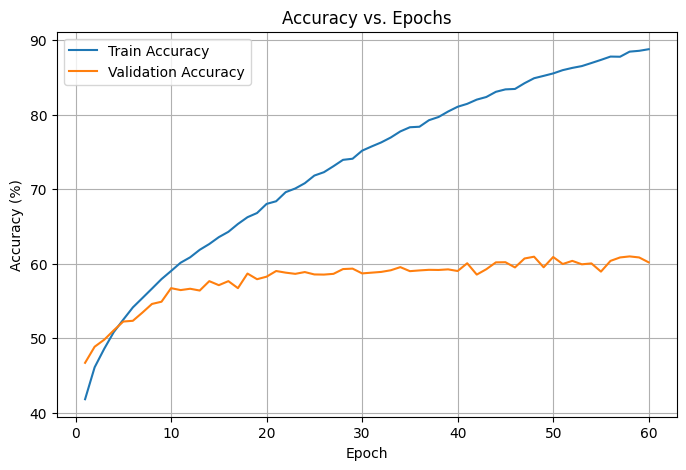

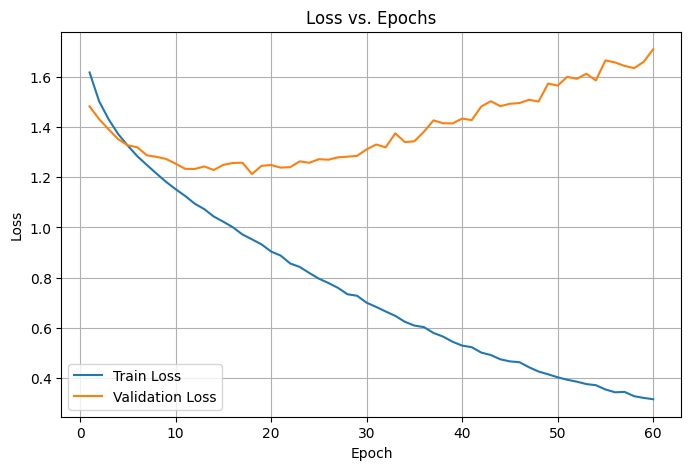

In [15]:
import matplotlib.pyplot as plt

# Create x-axis: epoch numbers starting from 1
epochs = range(1, len(history['train_loss']) + 1)

# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs, history['train_acc'], label='Train Accuracy')
plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `60%`

In [18]:
# After training is complete, evaluate on the test set:

test_loss, test_acc = eval_epoch(model, criterion, testloader, test_mode=True)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")

# Check if we exceeded 60%
if test_acc >= 60.0:
    print("✅ Achieved above 60% test accuracy!")
else:
    print("⚠️ Test accuracy is below 60%")


Test Loss: 1.7546 | Test Accuracy: 59.16%
⚠️ Test accuracy is below 60%


# Convolutional Neural Network

## Model

Define your model here from scratch (You are not allowed to use the existing models in pytorch)

**NOTICE:** The model that you will have defined outputs a vector containing 10 numbers (for each class). Define a "feature space" that is a vector of size *N* (where *N > 10*) right before the last layer (You can then have a last layer like `nn.Linear(N, 10)`). See the image below to get a better understanding. We will use this later (we want to access the feature space of a sample when the sample is given to the model). The model tries to learn a representation of the samples in this feature space and we will see how good it could do this in later sections.

![Feature Space In Neural Network](https://i.postimg.cc/28Qjcn9D/feature-space-vis.png)

 You are encouraged to learn about the following core components commonly used in convolutional neural networks:

* [`nn.Conv2d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
* [`nn.MaxPool2d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)

**Reminder**: The model you define should contain 33,500,000 ± 500,000 trainable parameters.

In [19]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        
        # feature extraction with conv + pooling
        self.features = nn.Sequential(
            nn.Conv2d(3,  64, kernel_size=3, padding=1),  # 32×32 → 32×32
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                               # → 16×16

            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # 16×16 → 16×16
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                               # → 8×8

            nn.Conv2d(128,256, kernel_size=3, padding=1),  # 8×8 → 8×8
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)                                # → 4×4
        )
        
        # flatten + two large FC layers define the "feature space" of size 4096
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),

            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout()
        )
        
        # final classification layer
        self.linear = nn.Linear(4096, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = self.linear(x)
        return x


## Trainable params

Based on the defined architecture, manually calculate the total number of trainable parameters:

Convolutional Layers
Each Conv2D layer has:

#params = (in_channels × kernel_size² × out_channels) + out_channels (bias)

1. Conv2d(3, 64, 3)
→ 
(
3
×
3
×
3
)
+
1
(3×3×3)+1 × 64 = (27 + 1) × 64 = 1,792

2. Conv2d(64, 128, 3)
→ 
(
3
×
3
×
64
)
+
1
(3×3×64)+1 × 128 = (576 + 1) × 128 = 73,728

3. Conv2d(128, 256, 3)
→ 
(
3
×
3
×
128
)
+
1
(3×3×128)+1 × 256 = (1,152 + 1) × 256 = 295,936

 Fully Connected Layers
After conv layers, feature map = 256×4×4 = 4096

4. Linear(4096, 4096)
→ 
(
4096
+
1
)
×
4096
(4096+1)×4096 = 16,781,312

5. Linear(4096, 4096)
→ 
(
4096
+
1
)
×
4096
(4096+1)×4096 = 16,781,312

6. Linear(4096, 10)
→ 
(
4096
+
1
)
×
10
(4096+1)×10 = 40,970

Total Trainable Parameters
1
,
792
+
73
,
728
+
295
,
936
+
16
,
781
,
312
+
16
,
781
,
312
+
40
,
970
=
33
,
974
,
050
1,792+73,728+295,936+16,781,312+16,781,312+40,970= 
33,974,050
​


Once you have completed your hand calculation, you can verify your result by running the following cell:

In [20]:
from torchsummary import summary
summary(CNN().to(device), input_size=(3, 32, 32));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]          73,856
              ReLU-5          [-1, 128, 16, 16]               0
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 256, 8, 8]         295,168
              ReLU-8            [-1, 256, 8, 8]               0
         MaxPool2d-9            [-1, 256, 4, 4]               0
          Flatten-10                 [-1, 4096]               0
           Linear-11                 [-1, 4096]      16,781,312
             ReLU-12                 [-1, 4096]               0
          Dropout-13                 [-1, 4096]               0
           Linear-14                 [-

## Train

### Model instantiation

Create an instance of your model and move it to `device`

In [21]:

# Model instantiation
model = CNN().to(device)  # YOUR CODE HERE


### Criterion & Optimizer

Define `criterion` and `optimizer`

In [22]:
import torch.nn as nn
import torch.optim as optim
# Criterion & Optimizer
criterion = nn.CrossEntropyLoss()                                # YOUR CODE HERE
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  # YOUR CODE HERE

### Train loop

Train your model

Tasks:
- Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- save train/validation loss and accuracy (of each epoch) in an array for later usage

In [23]:
epochs = 60 # Do not modify
history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, criterion, optimizer, trainloader)
    val_loss, val_acc = eval_epoch(model, criterion, valloader)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"(Epoch {epoch + 1} / {epochs}) train loss:{train_loss: .4f}; train acc:{train_acc: .2f}%; val loss:{val_loss: .4f}; val_acc:{val_acc: .2f}%")

(Epoch 1 / 60) train loss: 1.9390; train acc: 28.35%; val loss: 1.5494; val_acc: 42.30%
(Epoch 2 / 60) train loss: 1.4110; train acc: 47.97%; val loss: 1.2566; val_acc: 55.12%
(Epoch 3 / 60) train loss: 1.1666; train acc: 57.96%; val loss: 1.1158; val_acc: 59.76%
(Epoch 4 / 60) train loss: 0.9876; train acc: 64.66%; val loss: 0.9340; val_acc: 66.80%
(Epoch 5 / 60) train loss: 0.8465; train acc: 70.13%; val loss: 0.8355; val_acc: 71.00%
(Epoch 6 / 60) train loss: 0.7471; train acc: 73.62%; val loss: 0.8119; val_acc: 71.68%
(Epoch 7 / 60) train loss: 0.6403; train acc: 77.45%; val loss: 0.8559; val_acc: 69.88%
(Epoch 8 / 60) train loss: 0.5583; train acc: 80.34%; val loss: 0.7560; val_acc: 74.22%
(Epoch 9 / 60) train loss: 0.4779; train acc: 83.16%; val loss: 0.7717; val_acc: 74.06%
(Epoch 10 / 60) train loss: 0.4135; train acc: 85.59%; val loss: 0.7347; val_acc: 76.26%
(Epoch 11 / 60) train loss: 0.3314; train acc: 88.51%; val loss: 0.7444; val_acc: 76.08%
(Epoch 12 / 60) train loss: 0.

### Save Model

Since changes need to be made to the model later on, it is advisable to save your model to avoid having to retrain it in case of any issues.

In [24]:
torch.save({
    'model_state_dict': model.state_dict(),
    'history': history
}, "cnn_full.pth")


In [ ]:
checkpoint = torch.load("cnn_full.pth")
model.load_state_dict(checkpoint['model_state_dict'])
history = checkpoint['history']


<All keys matched successfully>

### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

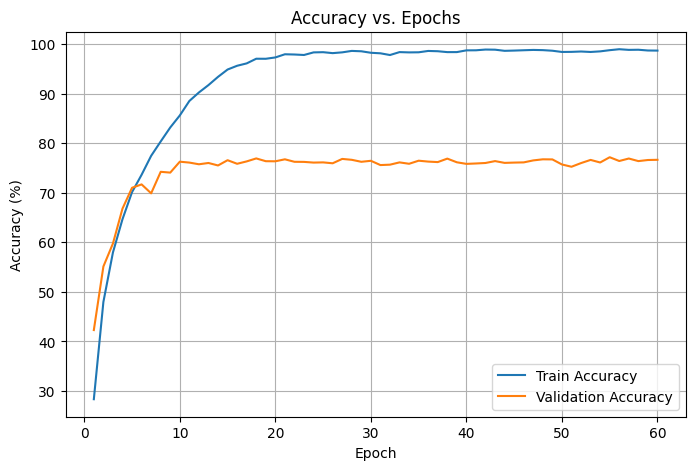

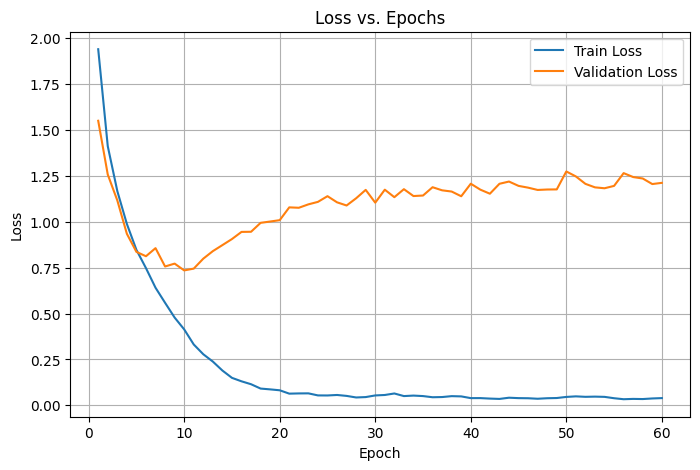

In [25]:
import matplotlib.pyplot as plt

# Create x-axis: epoch numbers starting from 1
epochs_range = range(1, len(history['train_loss']) + 1)

# Accuracy Plot
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, history['train_acc'], label='Train Accuracy')
plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

# Loss Plot
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, history['train_loss'], label='Train Loss')
plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `80%`

In [26]:
# Ensure model is in evaluation mode
model.eval()

correct = 0
total = 0
test_loss = 0.0

# We do not need gradients for evaluation
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)  # Sum loss
        
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

# Compute average loss and accuracy
avg_test_loss = test_loss / total
test_accuracy = 100 * correct / total

print(f"Test Loss: {avg_test_loss:.4f} | Test Accuracy: {test_accuracy:.2f}%")

if test_accuracy < 80:
    print("⚠️ Test accuracy is below 80%, consider improving your model architecture or training longer.")


Test Loss: 1.2632 | Test Accuracy: 76.74%
⚠️ Test accuracy is below 80%, consider improving your model architecture or training longer.


## Visualize incorrectly predicted samples from testset

Visualize *24* random images from testset that are incorrectly predicted by the model. Note that if you used normalization in the transform function for loading the data, you will need to unnormalize the images before displaying them.

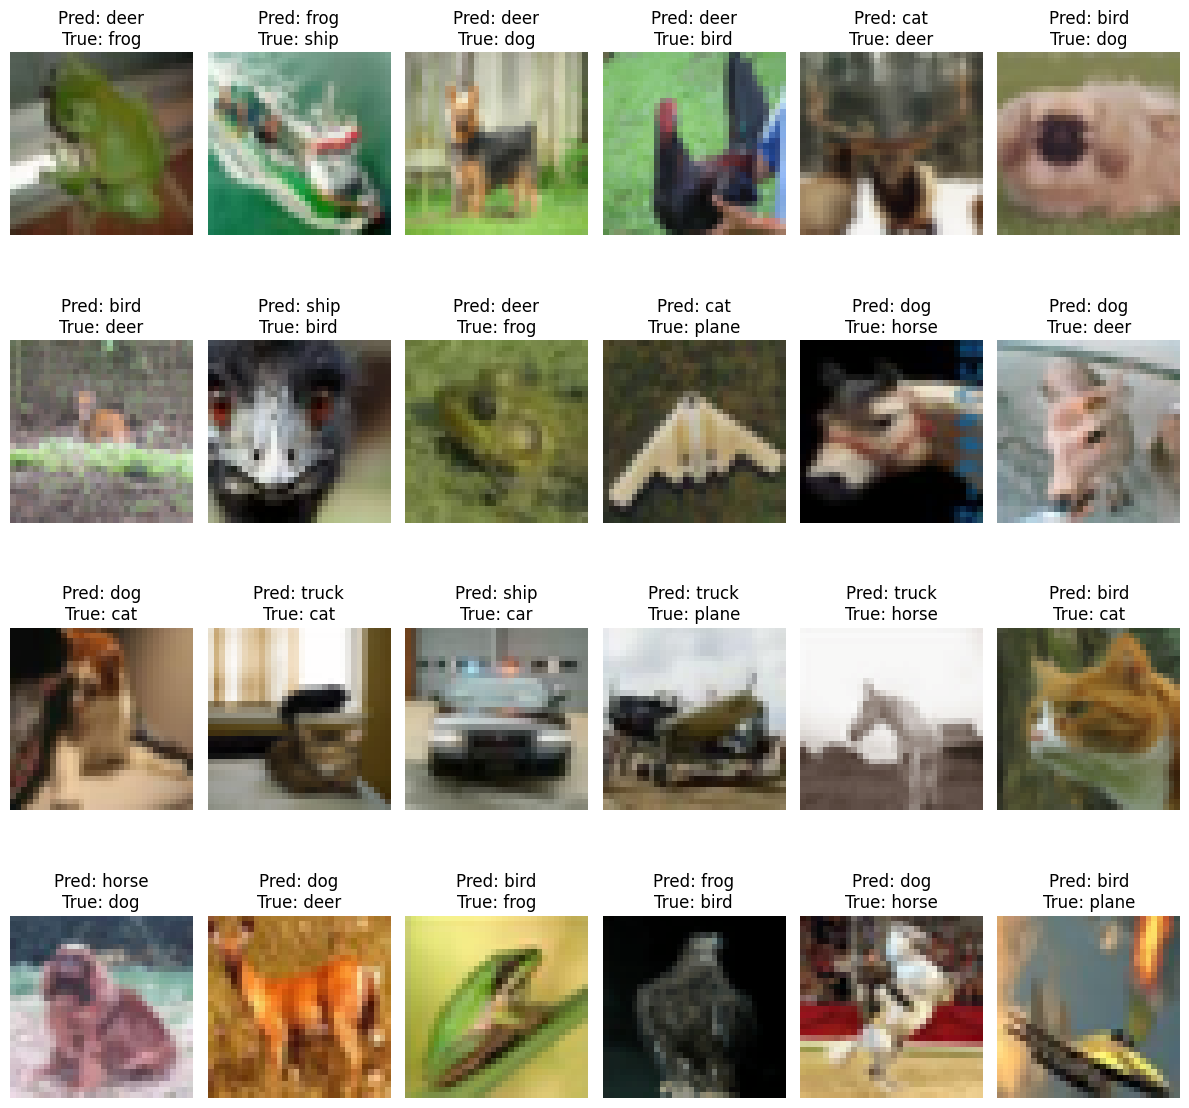

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import random

# CIFAR-10 class names
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Unnormalization function (using the same mean and std from your transform)
def unnormalize(img):
    mean = np.array([0.491, 0.482, 0.446])
    std = np.array([0.247, 0.243, 0.261])
    img = img * std[:, None, None] + mean[:, None, None]
    return np.clip(img, 0, 1)

# Set model to eval mode
model.eval()

incorrect_images = []
incorrect_preds = []
incorrect_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        incorrect = preds != labels

        for i in range(images.size(0)):
            if incorrect[i]:
                incorrect_images.append(images[i].cpu())
                incorrect_preds.append(preds[i].item())
                incorrect_labels.append(labels[i].item())

            if len(incorrect_images) >= 24:
                break
        if len(incorrect_images) >= 24:
            break

# Plot 24 incorrect samples
plt.figure(figsize=(12, 12))
for idx in range(24):
    img = incorrect_images[idx]
    img = unnormalize(img.numpy())
    img = np.transpose(img, (1, 2, 0))  # CHW to HWC

    plt.subplot(4, 6, idx + 1)
    plt.imshow(img)
    plt.title(f"Pred: {classes[incorrect_preds[idx]]}\nTrue: {classes[incorrect_labels[idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


## Exploring the feature space

### Calculate the feature space for all training samples

You have trained and evaluated your model. Now, for each sample in the trainset, calculate it's "feature space" discussed in the model section. The result of this section should be a tensor of size `(45000, N)` saved in a variable (for later usage)

- **Hint:** Pay attension to the `shuffle` attribute of your train dataloader (If needed)

In [28]:
# 1) Make sure we iterate in a fixed order
feature_trainloader = DataLoader(
    trainset,
    batch_size=512,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# 2) Build a small “feature extractor” from your trained model
#    this will run images through features→flatten→fc, and output the N-dim vector
feature_extractor = nn.Sequential(
    model.features,
    model.flatten,
    model.fc
).to(device)

# 3) Collect all features
all_features = []
model.eval()
with torch.no_grad():
    for images, _ in feature_trainloader:
        images = images.to(device, non_blocking=True)
        feats = feature_extractor(images)      # shape: (batch_size, N)
        all_features.append(feats.cpu())

# 4) Concatenate into one big tensor of shape (45000, N)
all_features_tensor = torch.cat(all_features, dim=0)
print("Feature space shape:", all_features_tensor.shape)


Feature space shape: torch.Size([50000, 4096])


### K Nearest Neighbor in feature space

We already have calculated the feature spaces for trainset ($S$) in the previous section. Now we follow these steps to explore the featre space:

1. Get 5 random samples from testset which are correctly predicted by the model.
2. for each sample, calculate it's "feature space" ($X$)
3. for each sample, calculate it's *5* nearest neighbors in "feature space" in the trainset (by comparing $X$ to each row in $S$) and visualize them

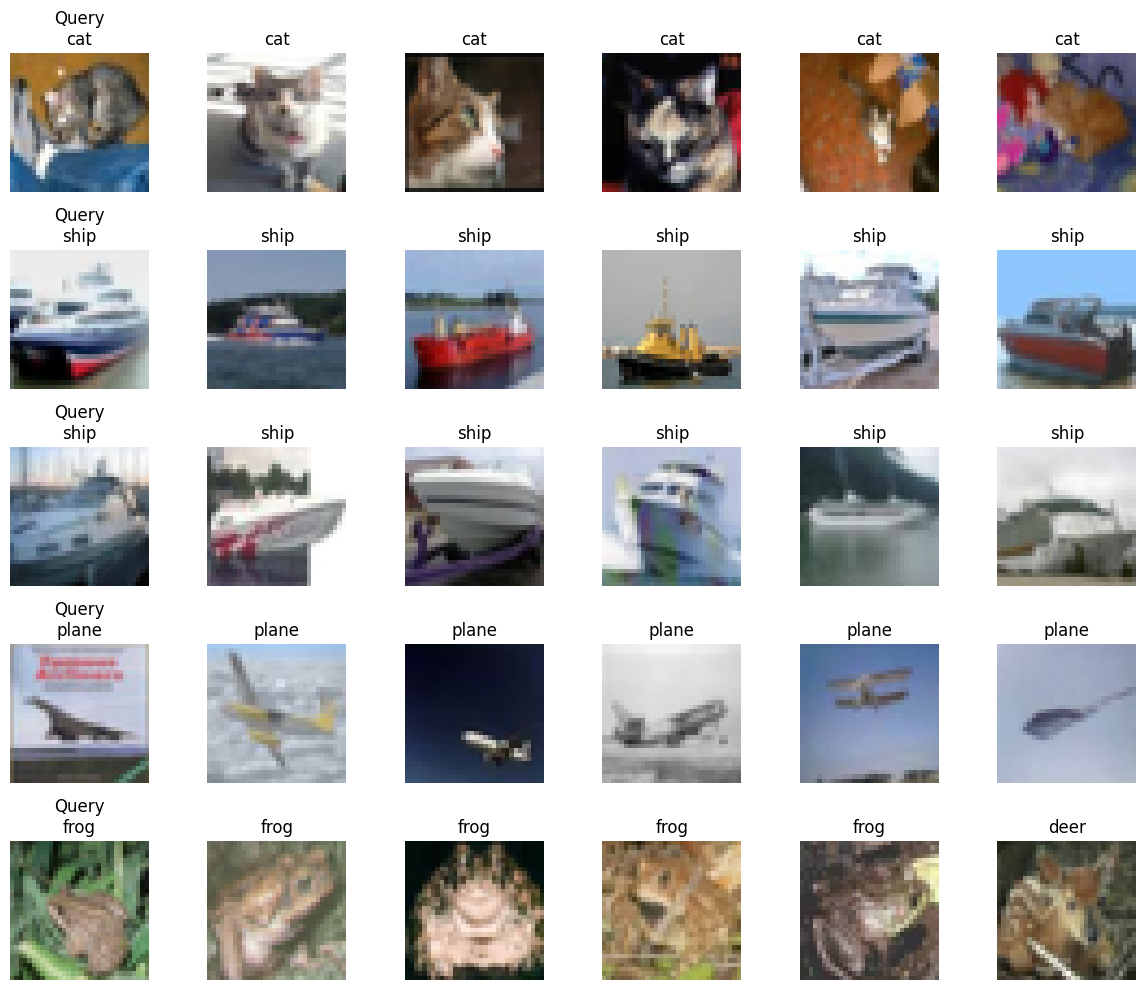

In [30]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# 1) Unnormalize helper (matches your original train mean/std)
feature_space = all_features_tensor
mean = torch.tensor([0.491, 0.482, 0.446])[:, None, None]
std  = torch.tensor([0.247, 0.243, 0.261])[:, None, None]
def unnormalize(img_tensor):
    img = img_tensor * std + mean
    return img.clamp(0, 1)

# 2) Collect 5 correctly predicted test samples
correct_samples = []
model.eval()
with torch.no_grad():
    for imgs, labels in testloader:
        imgs, labels = imgs.to(device), labels.to(device)
        outs = model(imgs)
        preds = outs.argmax(dim=1)
        for img, lbl, pred in zip(imgs, labels, preds):
            if pred == lbl:
                correct_samples.append((img.cpu(), lbl.item()))
                if len(correct_samples) == 5:
                    break
        if len(correct_samples) == 5:
            break

# 3) Visualize each sample + its 5 nearest neighbors
fig, axes = plt.subplots(5, 6, figsize=(12, 10))

for row, (img, true_lbl) in enumerate(correct_samples):
    # Unnormalize & prepare query image
    q_np = unnormalize(img).permute(1, 2, 0).numpy()
    axes[row, 0].imshow(q_np)
    axes[row, 0].set_title(f"Query\n{classes[true_lbl]}")
    axes[row, 0].axis('off')
    
    # Compute feature for this query
    with torch.no_grad():
        feat = feature_extractor(img.unsqueeze(0).to(device))
        feat = feat.squeeze(0).cpu()   # shape (N,)
    
    # Compute L2 distances to all train features
    dists = torch.norm(feature_space - feat, dim=1)  # (45000,)
    knn_idxs = torch.topk(dists, k=5, largest=False).indices
    
    # Plot the 5 nearest neighbors
    for col, idx in enumerate(knn_idxs, start=1):
        neigh_img, neigh_lbl = trainset[idx]     # Subset returns (tensor, label)
        neigh_np = unnormalize(neigh_img).permute(1,2,0).numpy()
        axes[row, col].imshow(neigh_np)
        axes[row, col].set_title(classes[neigh_lbl])
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()


### TSNE

Let's follow these steps to explore feature space even more:

1. Sample $M$ ($2000$ would be enought) random samples from the trainset feature space (calculated in the above sections)
2. Now we have a vector of size `(M, N)` where $N$ is the dimension of the feature space
3. Using TSNE reduce $N$ to $2$ (Now we have a vector of size `(M, 2)`)
4. Visualize the points in a 2D plane (Set color of each point based on it's class)


In [31]:
from sklearn.manifold import TSNE

indices = np.random.randint(0, len(feature_space), 2000)
feature_space = feature_space[indices]
tsne = TSNE(n_components=2, random_state=42)
reduced_space = tsne.fit_transform(feature_space.reshape(feature_space.shape[0], -1).detach().cpu().numpy())

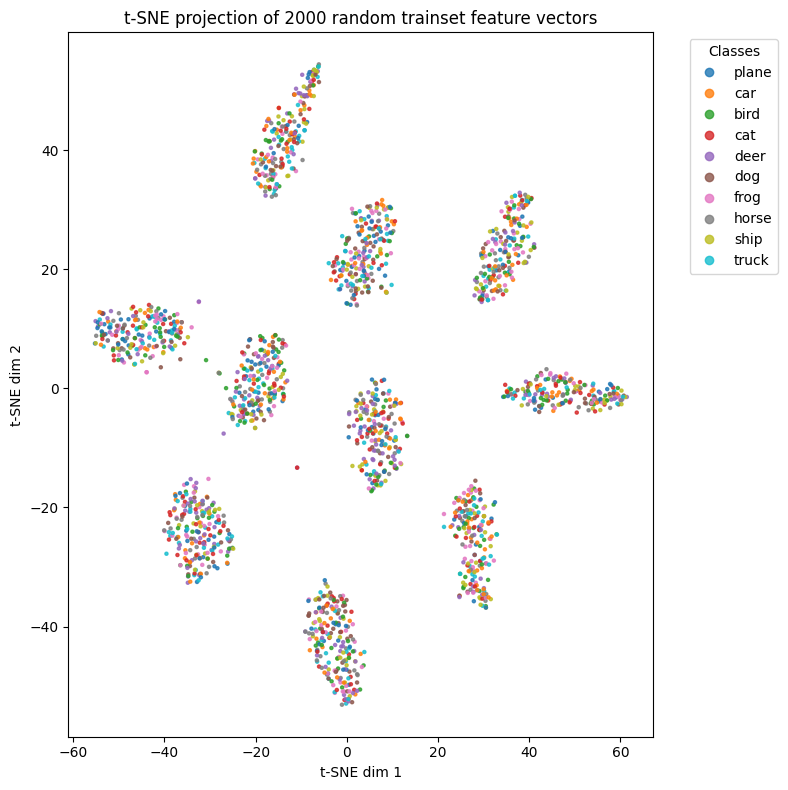

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 1) Sample M=2000 random feature vectors
M = 2000
total = feature_space.shape[0]
indices = np.random.choice(total, M, replace=False)
sampled_feats = feature_space[indices]            # shape: (M, N)

# 2) Get corresponding labels from the Subset
#    trainset is a torch.utils.data.Subset over CIFAR10, so:
# Fix: just index the targets directly
sampled_labels = np.array(trainset.targets)[indices]

# 3) TSNE reduction to 2D
tsne = TSNE(n_components=2, random_state=42)
reduced_space = tsne.fit_transform(sampled_feats.cpu().numpy())  # (M, 2)

# 4) Plot in 2D, colored by class
plt.figure(figsize=(8, 8))
scatter = plt.scatter(
    reduced_space[:, 0],
    reduced_space[:, 1],
    c=sampled_labels,
    cmap='tab10',
    s=5,
    alpha=0.8
)
# create legend
handles, _ = scatter.legend_elements(num=10)
plt.legend(handles, classes, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("t-SNE projection of 2000 random trainset feature vectors")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.tight_layout()
plt.show()


### Feature Map


In this part, we are going to visualize the output of one of the convolutional layers to see what features they focus on.

First, let's select a random image from dataset.

In [35]:
image = trainset[3][0]

Now, we are going to *clip* our model at different points to get different intermediate representation.
* Clip your model at least at one point and plot the filters output. You can use the output of first Resnet block.

In order to clip the model, you can use `model.children()` method. For example, to get output only after the first 2 layers, you can do:

```
clipped = nn.Sequential(
    *list(model.children()[:2])
)
intermediate_output = clipped(input)
```



Intermediate feature map shape: torch.Size([1024, 64, 32, 32])


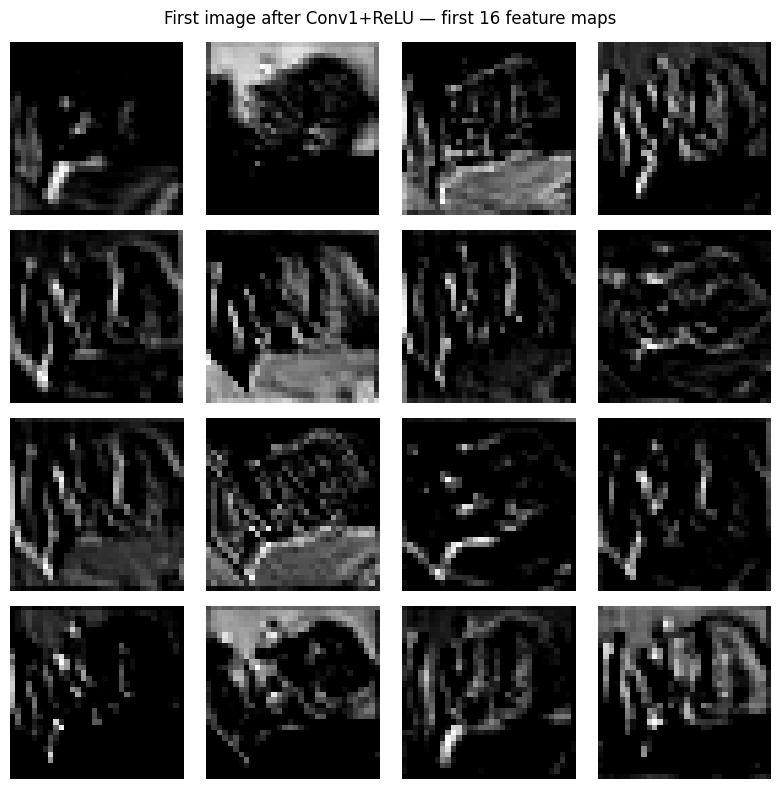

In [36]:
import torch.nn as nn
import matplotlib.pyplot as plt

# 1) Grab one batch of inputs
images, labels = next(iter(testloader))
inputs = images.to(device)

# 2) Clip the model after the first conv + ReLU in the features stack
#    model.features is Sequential([Conv2d, ReLU, MaxPool2d, ...])
clipped = nn.Sequential(
    *list(model.features.children())[:2]  # Conv2d + ReLU
).to(device)

# 3) Run the inputs through the clipped sub-model
intermediate_output = clipped(inputs)  # shape: (batch_size, 64, 32, 32)

print("Intermediate feature map shape:", intermediate_output.shape)

# 4) Visualize the first image's first 16 channels
feat_maps = intermediate_output[0].cpu().detach()
n_maps = 16
rows, cols = 4, 4

fig, axes = plt.subplots(rows, cols, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(feat_maps[i], cmap='gray')
    ax.axis('off')

plt.suptitle("First image after Conv1+ReLU — first 16 feature maps")
plt.tight_layout()
plt.show()


In [24]:
intermediate_output.shape

torch.Size([1024, 64, 32, 32])

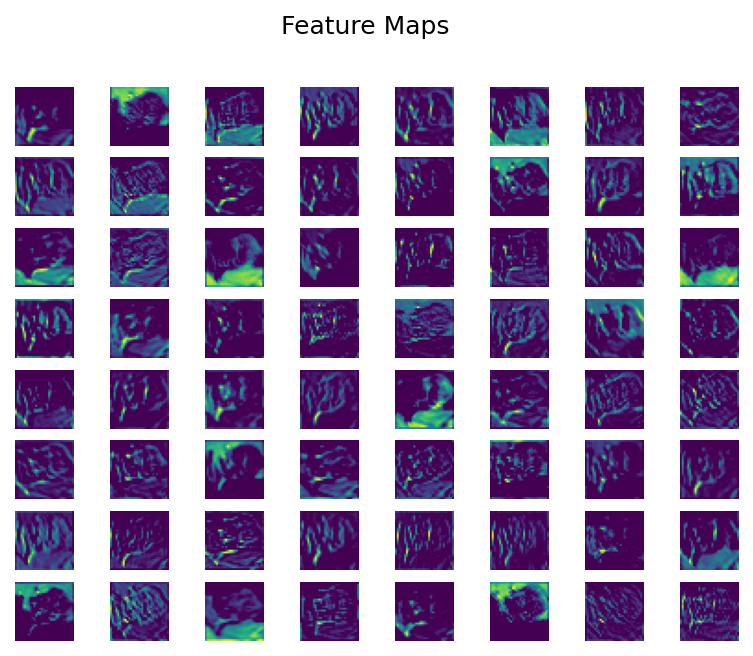

In [37]:
import math
import matplotlib.pyplot as plt

def plot_intermediate_output(result, title=None):
    """ 
    Plots the intermediate output of shape
    N_FILTERS x H x W
    """
    plt.rcParams['figure.dpi'] = 150
    n_filters = result.shape[1]
    N = int(math.sqrt(n_filters))
    M = (n_filters + N - 1) // N
    assert N * M >= n_filters

    fig, axs = plt.subplots(N, M)
    fig.suptitle(title)

    for i in range(N):
        for j in range(M):
            if i*N + j < n_filters:
                axs[i][j].imshow(result[0, i*N + j].cpu().detach())
                axs[i][j].axis('off')

plot_intermediate_output(intermediate_output, title='Feature Maps')


**Note:** You are expected to analyze all results presented in this notebook and thoughtfully consider the underlying reasons behind them. Be prepared to discuss your insights during the **in-person review session**.
A written report is not required.
